In [1]:
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt

# Name of DEM file
dem_fname = 'rcew_dem_5m_.tif'
# Number of bins for histogram / hypsometric curve
nbins = 35

In [2]:
# Open DEM
rcew_dem = rio.open(dem_fname)
rcew_dem

<open DatasetReader name='rcew_dem_5m_.tif' mode='r'>

In [3]:
# View DEM metadata
# Note: Units = m
rcew_dem.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -3.402823e+38,
 'width': 2940,
 'height': 5750,
 'count': 1,
 'crs': CRS.from_epsg(26911),
 'transform': Affine(5.0, 0.0, 511030.85,
        0.0, -5.0, 4795946.63)}

In [4]:
# Read the first time period and preview data
rcew_elev = rcew_dem.read(1)
rcew_elev

array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]], dtype=float32)

In [5]:
# Mask out no data values
rcew_elev = np.where(rcew_elev<0, np.nan, rcew_elev)

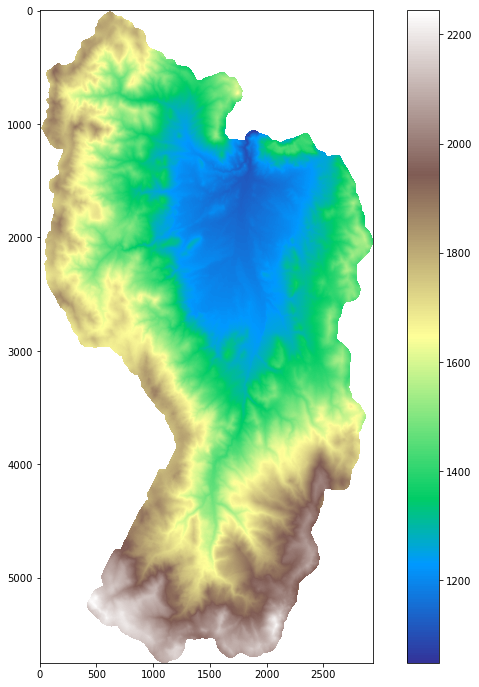

In [6]:
# Plot results
plt.figure(figsize=(12,12))
plt.imshow(rcew_elev, cmap='terrain')
plt.colorbar()
plt.show()

### Compute the Hypsometric Curve

f_elev:  [  1619  11914 152342 438122 594588 501777 456786 510649 470118 430887
 471721 469855 477990 427215 363346 354675 396460 423829 457140 434510
 417715 476529 390886 251801 185235 169748 164541 182518 173834 153810
 170081 113015  91200  42992  10121]
b_elev:  [1048.7723 1082.9165 1117.0605 1151.2047 1185.3489 1219.4929 1253.6371
 1287.7812 1321.9253 1356.0695 1390.2136 1424.3577 1458.5018 1492.646
 1526.79   1560.9342 1595.0784 1629.2224 1663.3666 1697.5106 1731.6548
 1765.799  1799.943  1834.0872 1868.2313 1902.3754 1936.5195 1970.6637
 2004.8077 2038.9519 2073.096  2107.2402 2141.3843 2175.5283 2209.6726
 2243.8167]
bin_centers:  [1065.8445 1099.9885 1134.1326 1168.2769 1202.4209 1236.565  1270.7092
 1304.8533 1338.9973 1373.1416 1407.2856 1441.4297 1475.574  1509.718
 1543.862  1578.0063 1612.1504 1646.2944 1680.4386 1714.5828 1748.7268
 1782.871  1817.0151 1851.1592 1885.3033 1919.4475 1953.5916 1987.7357
 2021.8799 2056.024  2090.168  2124.3123 2158.4563 2192.6006 2226.744

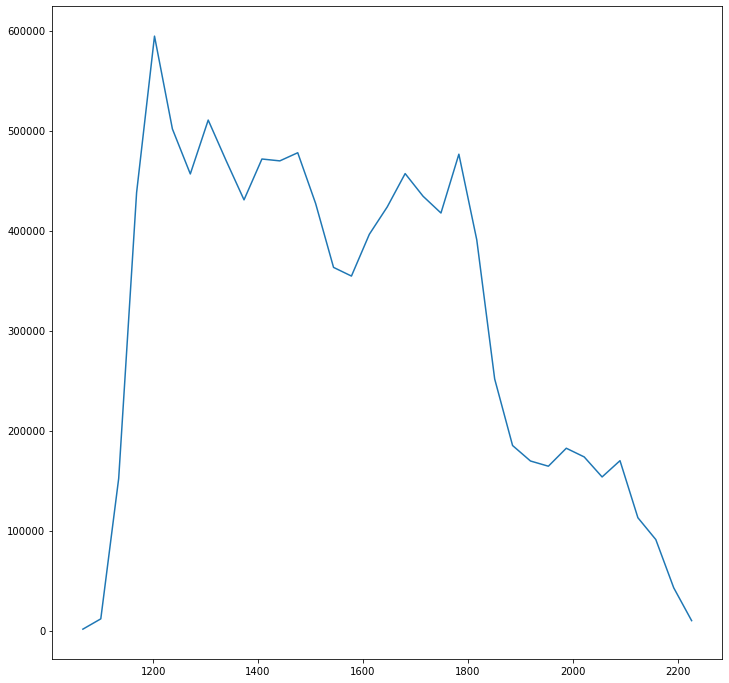

In [7]:
# Make sure NaNs are non included in histogram computation
f_elev,b_elev = np.histogram(rcew_elev[~np.isnan(rcew_elev)], bins=nbins)
print('f_elev: ',f_elev)
print('b_elev: ',b_elev)

# Compute bin centers (b_elev = bin edges)
bin_centers = (b_elev[0:-1] + b_elev[1:])/2
print('bin_centers: ',bin_centers)
plt.figure(figsize=(12,12))
plt.plot(bin_centers,f_elev)
plt.show()

In [8]:
hypso_rcew = 1.0 - np.cumsum(f_elev / np.sum(f_elev))
hypso_rcew

array([ 9.99850640e-01,  9.98751519e-01,  9.84697270e-01,  9.44278504e-01,
        8.89425032e-01,  8.43133800e-01,  8.00993194e-01,  7.53883480e-01,
        7.10512936e-01,  6.70761633e-01,  6.27243205e-01,  5.83896924e-01,
        5.39800153e-01,  5.00387608e-01,  4.66867271e-01,  4.34146874e-01,
        3.97571619e-01,  3.58471448e-01,  3.16298185e-01,  2.76212643e-01,
        2.37676516e-01,  1.93714529e-01,  1.57653501e-01,  1.34423703e-01,
        1.17334924e-01,  1.01674891e-01,  8.64952287e-02,  6.96571054e-02,
        5.36201209e-02,  3.94304423e-02,  2.37396893e-02,  1.33135367e-02,
        4.89991807e-03,  9.33708711e-04, -2.22044605e-16])

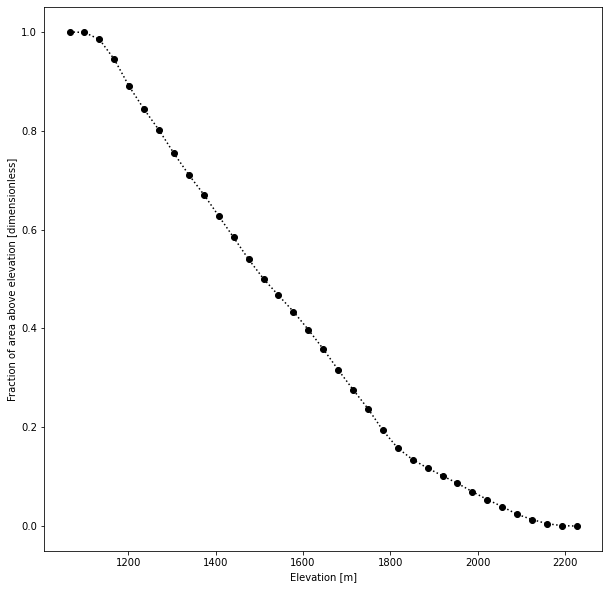

In [9]:
plt.figure(figsize=(10,10))
plt.plot(bin_centers,hypso_rcew,'ko:')
plt.xlabel('Elevation [m]')
plt.ylabel('Fraction of area above elevation [dimensionless]')
plt.show()

### Algorithm for Visualizing the Bottom and Top 1/3 of Elevation

1. Find the elevation corresponding to hypsometric curve value of (1/3) and (2/3), using `np.interp` (call it, for instance, `z_33` and `z_66`)

In [17]:
z_33 = np.interp(1/3,hypso_rcew,bin_centers)
z_66 = np.interp(2/3,hypso_rcew,bin_centers)
print('z_33 =',z_33,'m')
print('z_66 =',z_66,'m')

z_33 = 2226.74462890625 m
z_66 = 2226.74462890625 m


2. Use the `np.where(rcew_elev < z_66, , )` to get the bottom 1/3 of elevations and...  

3. use `plt.imshow()` to plot the Digital Elevation Models (DEMs) of the top and bottom 1/3 of the watersheds 